# Enron POI Detector
## 1. Data Exploration
Enron was a big scandal in Wallstreet that embodied greed, pride and fraud in Corporate America. Originally an energy company in Natural Gas, it became big when it started to trade energy in the stock exchange. They used this thing called "Mark-to-Market" pitch that basically allows them to sell their stock by reporting future earnings. Imagine if someone approached you and told you to invest in their company that will make 100 million USD even if their powerplant was not yet built. Naturally, everyone bought it and their prices went up. Long story short, the businesses went bankrupt after reporting huge losses and their investors lost their money. People responsible were called into question to answer for the fraud that they have commited.

## 1.1. Objective of Analysis
The objective of this analysis is create an algorithm that will be able to identify Person of Interests or POI by using their emails and financials.

## 1.2. Summary of Dataset
The dataset contains 146 People with 21 Features. The features are split according to Email and Financials of these people. There are 18 People marked as Person of Interest, which includes CEO Jeffrey Skillings, Chairman Kenneth Lay and CFO Andrew Fastow. 

In [137]:
#!/usr/bin/python
import sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'bonus', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'other', 'long_term_incentive', 
                 'restricted_stock', 'director_fees', 'to_messages', 
                 'from_poi_to_this_person', 'from_messages', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Counts to describe the dataset
print "Count of People: ", len(my_dataset.keys())
print "Count of Features: ", len(my_dataset["METTS MARK"].keys())
print "Count of POI: ", len(dict([(k,r) for k,r in my_dataset.iteritems() if r['poi'] == 1]))

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys=True, remove_all_zeroes=False)

Count of People:  146
Count of Features:  21
Count of POI:  18


## 1.3. Outlier Removal
I made a scatter plot with salary and bonus in my axis to see any outliers in the dataset. Upon investigation, I discovered that *TOTAL* is included in the dataset, which is an outlier. In addition, I am seeing *THE TRAVEL AGENCY IN THE PARK* as another entry. Since we are developing a *Person* of of Interest detector, we remove this non-person entry.

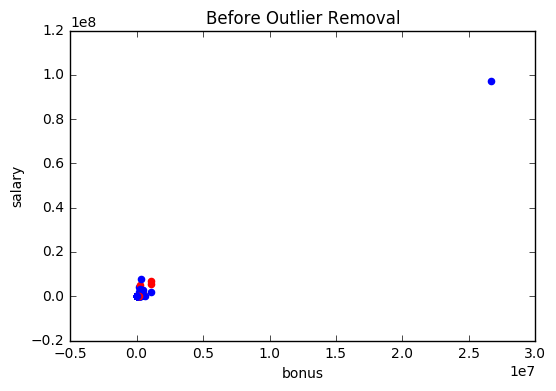

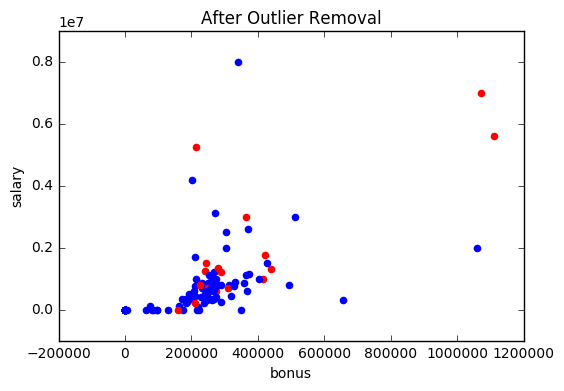

In [138]:
### Task 2: Remove outliers
### Scatterplot function that marks the person of interest in red.
def plotScatter(dat, title, labels=features_list):
    for point in dat:
        poi = point[0]
        if poi == 0:
            plt.scatter(point[1], point[2], color = "blue")
        else:
            plt.scatter(point[1], point[2], color = "red")
    plt.ylabel(labels[1])
    plt.xlabel(labels[2])
    plt.title(title)
    plt.show()
    
plotScatter(data, "Before Outlier Removal")
data_dict.pop("THE TRAVEL AGENCY IN THE PARK", 0)
data_dict.pop("TOTAL", 0)
data = featureFormat(my_dataset, features_list, sort_keys=True, remove_all_zeroes=False)
plotScatter(data, "After Outlier Removal")

## 2.2. Create New Features
I suspect that POIs would be the ones who are either getting the most salaries or bonuses. But simply adding these two features would give us inconsistent results since they vary in scales. Therefore, for my first feature, I add the scaled versions of the salary and bonus and call it *bonus_salary*. In addition, **I have scaled all the features in the features_list to effectively normalize the features.**

I also assumed that POIs have a small circle and they would have constant communication with each other. AS a result, for my second feature, I divide the total emails sent to a POI over the total sent emails and call it *emailto_poi*.

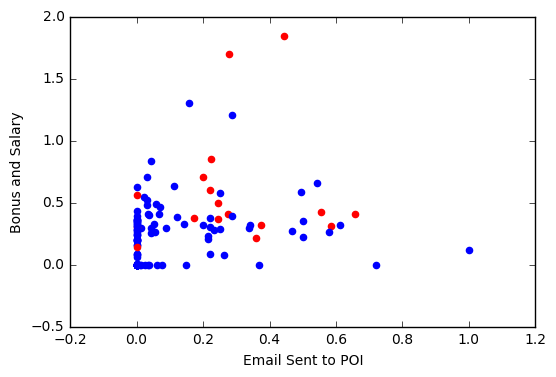

In [139]:
### Task 3: Create new feature(s)
from sklearn.preprocessing import MinMaxScaler

labels, features = targetFeatureSplit(data)

def doScale(dat):
    scaler = MinMaxScaler()
    rescaled = scaler.fit_transform(dat)
    return rescaled

def addNewFeature(dat, num, name):
    new = {}   
    keys = []
    if name not in features_list:
        features_list.append(name)

    for key in dat.keys():
        keys.append(key)
    keys = sorted(keys)
    for i, f in enumerate(keys):
        elem = {}
        elem[name] = num[i][0]
        for key, val in dat[f].items():
            elem[key] = val
        new[f] = elem
    return new

def selectFeatures(dat, var):
    new = []
    feat = []
    for i, u in enumerate(var):
        feat.append(features_list.index(u) - 1)
        
    for v in dat:
        elem = []
        for f in feat:
            elem.append(v[f])
        new.append(elem)
    return np.array(new)

def compute(dat, how):
    new = []
    if how == "sum":
        for i in dat:
            elem = []
            total = sum(i)
            elem.append(total)            
            new.append(elem)
    elif how == "divide":
        for i in dat:
            elem = []
            if (i[0] <= 0) | (i[1] <= 0):
                elem.append(0.)
            else:
                elem.append(i[0] / i[1])
            new.append(elem)
    return np.array(new)

def plotComparison(labels, feat1, feat2):
    for xx, jj, ii in zip(labels, feat1, feat2):
        if xx == 0:
            plt.scatter(jj, ii, color="b")
        else:
            plt.scatter(jj, ii, color="r")
        
    plt.ylabel("Bonus and Salary")
    plt.xlabel("Email Sent to POI")
    plt.show()

feat_re = doScale(features)
bonus_re = selectFeatures(feat_re, ["bonus", "salary"])
bonus_sm = compute(bonus_re, "sum")

email_from = selectFeatures(features, ["from_this_person_to_poi", "from_messages"])
emailto_poi = compute(email_from, "divide")

plotComparison(labels, emailto_poi, bonus_sm)

my_dataset = addNewFeature(my_dataset, bonus_sm, "bonus_salary")
my_dataset = addNewFeature(my_dataset, emailto_poi, "emailto_poi")

## 2.2. Test Custom Features
After creating my new features, I put them to the test. Below are the results:

SVM 
- accuracy score:  0.8864
- precision score:  0.0
- recall score:  0.0

Decision Tree 
- accuracy score:  0.8636
- precision score:  0.3333
- recall score:  0.2

Gaussian
- accuracy score:  0.8409
- precision score:  0.0
- recall score:  0.0

The SVM seems to be producing the greatest accuracy score but it is not good in identifying our POIs in terms of precision and recall. The second best classifier is the Decision Tree where it scored 0.8638 in accuracy and was able to score 0.33 and 0.2 in precision and recall, respectively. Using Gaussian Naive Bayes as a classifier is the least performing amongst the 3 classifiers.

I add *bonus_salary* and *emailto_poi* to my_dataset.

In [140]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.naive_bayes import GaussianNB as GNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

data = featureFormat(my_dataset, features_list, sort_keys=True, remove_all_zeroes=False)
labels, features = targetFeatureSplit(data)

custom_features = selectFeatures(features, ["bonus_salary", "emailto_poi"])

features_train, features_test, labels_train, labels_test = \
    train_test_split(custom_features, labels, test_size=0.3, random_state=42)

clf = SVC()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print "SVM accuracy score: ", round(accuracy_score(labels_test, pred), 4)
print "SVM precision score: ", round(precision_score(labels_test, pred), 4)
print "SVM recall score: ", round(recall_score(labels_test, pred), 4)
print

clf = DTC()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print "Decision Tree accuracy score: ", round(accuracy_score(labels_test, pred), 4)
print "Decision Tree precision score: ", round(precision_score(labels_test, pred), 4)
print "Decision Tree recall score: ", round(recall_score(labels_test, pred), 4)
print

clf = GNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print "Gaussian accuracy score: ", round(accuracy_score(labels_test, pred), 4)
print "Gaussian precision score: ", round(precision_score(labels_test, pred), 4)
print "Gaussian recall score: ", round(recall_score(labels_test, pred), 4)
print

SVM accuracy score:  0.8864
SVM precision score:  0.0
SVM recall score:  0.0

Decision Tree accuracy score:  0.8636
Decision Tree precision score:  0.3333
Decision Tree recall score:  0.2

Gaussian accuracy score:  0.8409
Gaussian precision score:  0.0
Gaussian recall score:  0.0



## 2.3. Automated Feature Selection
I want to make sure that I have covered everything. So, after adding my new features to *my_dataset*, I use SelectKBest to choose the best features that would give me the most information. Then, I print out each feature ranked according to their scores. Reviewing the results, it seems that my features are within the the top 6 of the best features.

In [141]:
from sklearn.feature_selection import SelectKBest

data = featureFormat(my_dataset, features_list,
                     sort_keys=True, remove_all_zeroes=False)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

clf = SelectKBest(k = 6)
clf.fit_transform(features_train, labels_train)
features_train_tr = clf.transform(features_train)
features_train_ts = clf.transform(features_test)

def findScores(score, names):
    new = {}
    board = []
    player = []
    for i, value in enumerate(score):
        player.append(names[i+1])
        board.append(round(value, 2))
    new["feature"] = player
    new["score"] = board
    return pd.DataFrame(new).sort_values(by=["score"], 
                                     ascending=False).set_index('feature', drop=True)

feature_sc = findScores(clf.scores_, features_list)
print feature_sc

                           score
feature                         
bonus                      34.21
bonus_salary               27.96
salary                     17.77
exercised_stock_options    16.93
total_stock_value          16.87
deferred_income            16.37
shared_receipt_with_poi    12.89
long_term_incentive        11.22
restricted_stock            9.79
total_payments              8.84
emailto_poi                 8.47
loan_advances               7.04
from_poi_to_this_person     6.18
to_messages                 5.49
expenses                    5.38
other                       3.36
director_fees               1.82
restricted_stock_deferred   0.70
from_messages               0.41
deferral_payments           0.05
from_this_person_to_poi     0.03


## 3.1. Try a Variety of Classifiers and Pick the Best
After trying several Classifiers, I ended up choosing *scalepcadtc* as my classifier because it had the good score in precision and recall. Below are the results of each classifier that I have used and the sequence of model.

- 0.84 : SelectKBest, RandomForest
- 0.89 : Scale, PCA, SVC
- 0.86 : SelectKBest, GaussianNB
- 0.84 : Scale, PCA, DecisionTree

In [142]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report as classReport

def doPipes(steps):
    pipe = Pipeline(steps)
    pipe.fit(features_train, labels_train).predict(features_test)
    return pipe

def getAccuracy(pipe):
    pred = pipe.fit(features_train, labels_train).predict(features_test)
    return round(accuracy_score(labels_test, pred), 2)

def getClassReport(pipe):
    pipe.fit(features_train, labels_train)
    pred = pipe.predict(features_test)
    return classReport(labels_test, pred)

scalepcasvc = doPipes([
    ("scale", MinMaxScaler()),
    ("pca", PCA()),
    ("svc", SVC())
])

selectKrfc = doPipes([
    ("selectK", SelectKBest()),
    ("rfc", RFC())
])

selectKsteps = doPipes([
    ("selectK", SelectKBest()),
    ("gnb", GNB())
])

scalepcadtc = doPipes([
    ("scale", MinMaxScaler()),
    ("pca", PCA()),
    ("dtc", DTC())
])

print "SelectKBest, RandomForest"
print getAccuracy(selectKrfc), ": Accuracy Score"
print getClassReport(selectKrfc)
print "Scale, PCA, SVC"
print getAccuracy(scalepcasvc), ": Accuracy Score"
print getClassReport(scalepcasvc)
print "SelectKBest, GaussianNB"
print getAccuracy(selectKsteps), ": Accuracy Score"
print getClassReport(selectKsteps)
print "Scale, PCA, DecisionTree"
print getAccuracy(scalepcadtc), ": Accuracy Score"
print getClassReport(scalepcadtc)

SelectKBest, RandomForest
0.89 : Accuracy Score
             precision    recall  f1-score   support

        0.0       0.88      0.97      0.93        39
        1.0       0.00      0.00      0.00         5

avg / total       0.78      0.86      0.82        44

Scale, PCA, SVC
0.89 : Accuracy Score
             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        39
        1.0       0.00      0.00      0.00         5

avg / total       0.79      0.89      0.83        44

SelectKBest, GaussianNB
0.86 : Accuracy Score
             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92        39
        1.0       0.40      0.40      0.40         5

avg / total       0.86      0.86      0.86        44

Scale, PCA, DecisionTree
0.84 : Accuracy Score
             precision    recall  f1-score   support

        0.0       0.90      0.90      0.90        39
        1.0       0.20      0.20      0.20         5

avg / total    

## 4.1. Tune Best Algorithm
After selecting my classifier, I then tune the parameters in an attempt to find the appropriate configuration that would give me the best results. If I do not do this well or if I do not do it at all, I will run the risk of missing out on the best configuration of my chosen classifier. To help me tune my parameters, I will be using *GridSearchCV* to help me run several versions of the parameters and find the best one. I try a PCA range from 2, 4 and 6 components and a DecisionTreeClassifier that had minimum sample split of 6 and 7.

In [143]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn.grid_search import GridSearchCV as GridSVC

param = dict(
    pca__n_components = [2, 4, 6],
    dtc__min_samples_split = [6, 7]
)

clf = scalepcadtc # My Best Algorithm

cv = GridSVC(clf, param_grid=param)

## 5.1. Validation
Validation allows us to check our algoritm's effectiveness by splitting our dataset where we can train our algorithm on one set and test on another, which helps us check for overfitting. 

In this analysis, I have been using *train_test_split* to split our data where 30% goes to testing and 70% goes to training set. But to test my best algorithm and the alternative algorithm, I use *StratifiedShuffleSplit*, which returns a a stratified randomized folds. I maintained splits of 2 and a test size of 30%. This is much better than *train_test_split* because it shuffles the dataset while keeping the percentage of the target class to the overall dataset, which is ideal for a small dataset such as this one.

## 6.1. Evaluation Metrics
Running getClassReport, I get an accuracy score of 0.75 for my chosen classifier. After running the *getClassReport*, I get an average precision score of 0.40, which means that my classifier has a 40% of a chance to correctly identify a POI out of the all of the items labeled as POIs in the dataset. I also got a recall score of 0.40, which means that, out of the total True POIs, our algorithm is able to identify 40% of the True POIs.

The best parameters according to the Grid Search is if we set the *min_samples_split* of the Decision Tree Classifier to 6 and if we select only 2 components in the PCA. The first PCA component explains 23% of the variation in the data and th second component 8%.

    Best Algorithm
    Scale, PCA, DTC
    0.75: Accuracy Score
    
    Validation Score
    labels    precis    recall    F1       support
    0.0       0.92      0.92      0.92     39
    1.0       0.40      0.40      0.40      5
              0.86      0.86      0.86     44      avg / total
              
    Best Parameters:  {'dtc__min_samples_split': 6, 'pca__n_components': 2}
    PCA explained variance:  [ 0.22663112  0.08181349]
              
Had I chosen the *scalepcasvc* (without tuning the parameters), it will give me a high accuracy score of 0.89 but a 0.0 precision score and 0.0 recall score in identifying POIs. Accuracy simply takes the number of points that the algorithm has labeled correctly, either 0.0 or 1.0, and divide it by the total number of datapoints. In this scenario, our algorithm is able to recall all non-POIs (labeled 0.0) but it was not able to recall any POIs (labeled 1.0). In addition, with a precision of 0.89 at identifying non-POIs, I would suspect that the algorithm are just identifying all datapoints as non-POIs.

    Alternative Algorithm
    Scale, PCA, SVC
    0.89 : Accuracy Score
    
    Validation Score
                 precision    recall  f1-score   support

            0.0       0.89      1.00      0.94        39
            1.0       0.00      0.00      0.00         5

    avg / total       0.79      0.89      0.83        44
    


In [144]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
for train, test in sss.split(features, labels):
    features_train = [features[ii] for ii in train]
    features_test = [features[ii] for ii in test]
    labels_train = [labels[ii] for ii in train]
    labels_test = [labels[ii] for ii in test]

print "Best Algorithm"
print getAccuracy(cv), ": Accuracy Score"
print getClassReport(cv)
print "Best Parameters: ", cv.best_params_
print "PCA explained variance: ", cv.best_estimator_.named_steps["pca"].explained_variance_
print
print "Alternative Algorithm"
print getAccuracy(scalepcasvc), ": Accuracy Score"
print getClassReport(scalepcasvc)

Best Algorithm
0.75 : Accuracy Score
             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92        39
        1.0       0.40      0.40      0.40         5

avg / total       0.86      0.86      0.86        44

Best Parameters:  {'dtc__min_samples_split': 6, 'pca__n_components': 2}
PCA explained variance:  [ 0.22663112  0.08181349]

Alternative Algorithm
0.89 : Accuracy Score
             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        39
        1.0       0.00      0.00      0.00         5

avg / total       0.79      0.89      0.83        44



In [145]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

## Sources
- https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/
- http://abshinn.github.io/python/sklearn/2014/06/08/grid-searching-in-all-the-right-places/
- http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
- http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
- http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html